In [38]:
### 5.误差反向传播
import numpy as np
import sys
import matplotlib.pyplot as plt
from book_material.common.optimizer import Adam
from book_material.dataset.mnist import load_mnist

In [59]:
###随机梯度SGD
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self,param,grad):
        if isinstance(param,dict):
            for key in param:
                param[key] -= self.lr * grad[key]
        else:
            param -= self.lr*grad
        return param
##动量法
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v=None
    def update(self,param,grad):
        if self.v is None:
            self.v=dict()
            for i in param.keys():
                self.v[i]=np.zeros_like(param[i])
        for key in param.keys():
            self.v[key] = self.momentum*self.v[key]-self.lr * grad[key]
            param[key] += self.v[key]


##自适应梯度
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr = lr
        self.h = None
    def update(self,param,grad):
        if self.h is None:
            self.h=dict()
        for key in param.keys():
            self.h[key]=np.zeros_like(param[key])

        for key in param.keys():
            self.h[key]=self.h[key]+grad[key]*grad[key]
            param[key] -=self.lr*grad[key]*1/np.sqrt(self.h[key]+1e-7)

In [60]:
# 读入数据b
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

In [61]:
import sys,os
from book_material.common.functions import  *
from book_material.common.gradient import *
from book_material.common.layers import *
import numpy as np
from collections import OrderedDict
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        ##初始化权重
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
        ###生成层
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    ## x输入数据 t监督数据
    def loss(self,x,t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)
    def accuracy(self,x,t):
        y=self.predict(x)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        result=np.argmax(y,axis=1)
        return np.sum(result==t)/float(x.shape[0])
    def numerical_gradient(self,x,t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self,x,t):
        self.loss(x,t)
        dout=1
        dout=self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for i in layers:
            dout=i.backward(dout)
        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [72]:


###几种梯度下降法
sgd=SGD(lr=0.1)
m=Momentum(lr=0.1)
ada=AdaGrad(lr=0.1)
adam=Adam(lr=0.1)

optimizers=dict()
optimizers['sgd']=sgd
optimizers['momentum']=m
optimizers['ada']=ada
optimizers['adam']=adam

test_accuracy_list=dict()
test_accuracy_list['sgd']=[]
test_accuracy_list['momentum']=[]
test_accuracy_list['ada']=[]
test_accuracy_list['adam']=[]

for key in optimizers.keys():
    ###误差反向传播
    network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
    train_shape=x_train.shape[0]
    num=300
    learn_rate=0.1
    loss_list=[]
    for i in range(num):
        batch_mask=np.random.choice(np.arange(x_train.shape[0]), size=100, replace=True)
        grads=network.gradient(x_train[batch_mask],t_train[batch_mask])
        optimizers[key].update(network.params,grads)
        test_accuracy_list[key].append(network.accuracy(x_test,t_test))

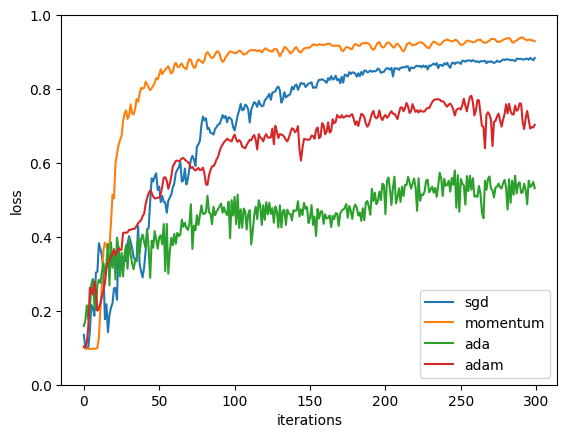

In [73]:
from matplotlib import pyplot as plt
markers = {"sgd": "o", "m": "x", "ada": "s", "adam": "D"}
x = np.arange(num)
for key in optimizers.keys():
    plt.plot(x, test_accuracy_list[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [51]:
test_accuracy_list[key]

[]